# Classification

### Prerequisites
- [Intro to PyTorch](https://github.com/AI-Core/Neural-Networks/blob/master/Intro%20to%20PyTorch.ipynb)

Most tasks can be either defined as regression (predicting a continuous value e.g. house price) or classification (predicting a discrete value e.g. cat vs dog in images) problems.

The simplest form of a classification problem is binary classification, where an example either belongs to a class or doesn't and there is only one class. That is, every example has a lable which is either true or false.

In classification, we can interpret the output as a confidence (probability) that the example belongs to that class. Because 

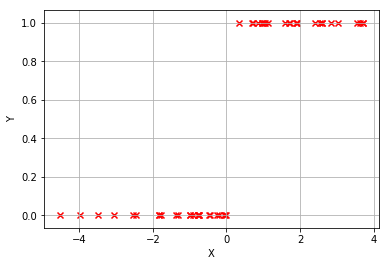

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def make_binary_data(m=50): 
    X = np.random.randn(m) #sample from a normal distribution
    Y = X > 0.2    # return binary vector with true where X above some threshold and false if below
    return X, Y #returns X (the input) and Y (labels)

def plot_data(X, Y):
    plt.figure()
    plt.scatter(X, Y, c='r', marker='x')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid()
    plt.show()
    
X, Y = make_binary_data()
plot_data(X, Y)

## Let's build our binary classifier model class

The model is going to be almost identical to the model that we've used for linear regression, except from the fact that the output will need be transformed using the sigmoid function so that it lies within the range 0-1 to represent a confidence of the example belonging to the positive class. We can find a PyTorch implementation of the sigmoid function [here](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid).

![](./images/sigmoid.jpg)

Let's implement our classifier class

In [33]:
import torch
import torch.nn.functional as F

class Classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = torch.nn.Linear(1, 1) #define the linear transformation
        
    def forward(self, x):
        x = self.linear_layer(x) #apply linear transformation
        x = F.sigmoid(x) #add a sigmoid activation function to the end
        return x

## The loss function for binary classification

Unlike in regression problems, how we measure the loss for a particular example in a classification problem depends on what the label is. That is, if the label is 1 (yes, it belongs to the positive class) then we want to penalise it more for having a prediction nearer to 0 (no, it belongs to the negative class), and vice versa.

### Binary cross entropy

![](./images/bce.jpg)
[Cross entropy](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.cross_entropy)

/home/haron/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


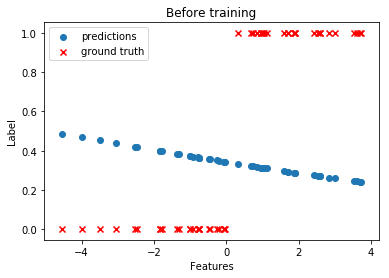

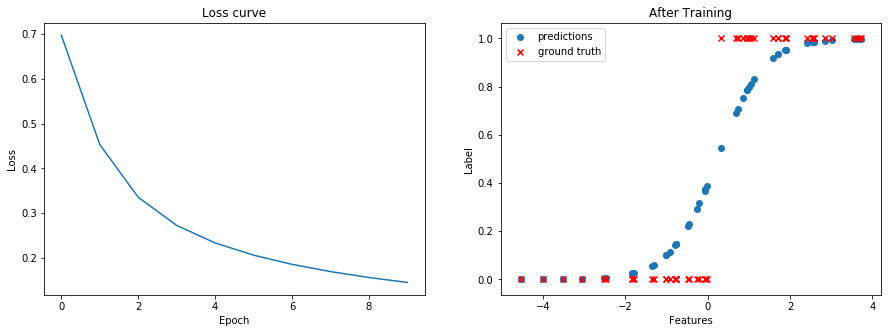

In [41]:
import matplotlib.pyplot as plt

X, Y = torch.tensor(X).view(-1, 1), torch.tensor(Y).view(-1, 1) #convert data to tensors and add batch dimension
Y = Y.double() #convert Y to a double

H = Classifier().double() # initialise classifier and convert to double
optimiser = torch.optim.Adam(H.parameters(), lr=0.01)# create optimiser

# PLOT OUR HYPOTHESIS BEFORE TRAINING
plt.figure()
plt.title('Before training')
plt.ylabel('Label')
plt.xlabel('Features')
plt.scatter(X, H(X).detach(), label='predictions')
plt.scatter(X, Y, c='r', marker='x', label='ground truth')
plt.legend()
plt.show()

epochs = 1000
losses = []
for epoch in range(epochs):
    epoch_losses = []
    for x, y in zip(X, Y):
        prediction = H(x) # make prediction
        loss = F.binary_cross_entropy(prediction, y) # compute loss
        loss.backward() # calculate derivatives
        optimiser.step() # make optimisation step
        optimiser.zero_grad() # reset gradients
        epoch_losses.append(loss)
    losses.append(sum(epoch_losses)/len(epoch_losses))
        
# PLOT THE LOSS CURVE AND OUR HYPOTHESIS AFTER TRAINING
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax1.set_title('Loss curve')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.plot(losses)

ax2 = fig.add_subplot(122)
ax2.set_title('After Training')
ax2.set_ylabel('Label')
ax2.set_xlabel('Features')
ax2.scatter(X, H(X).detach(), label='predictions')
ax2.scatter(X, Y, c='r', marker='x', label='ground truth')
ax2.legend()
plt.show()

## Binary classification vs multiclass classification

In binary classification the output must be either true or false. Either the example falls into this class, or it doesn't. We have seen that we can represent this by our model having a single output node whose value is forced between 0 and 1, and as such represents a confidence in the fact that the example belongs to the positive class. Alternatively, still for binary classification, we could have two output nodes, where the value of the first represents the confidence that the input belongs to the positive class (true/class 1) and the value of the second represents the confidence that the input belongs to the negative class (false/class 2). In this case, the values of each output node must be positive and they must sum to 1, because this output layer represents a probability distribution over the output classes. 

![](./images/binary-class.jpg)

In the case where we have two nodes to represent true and false, we can think about it as having trained two models, which have exactly the same weights in every layer except for the last. 

Treating true and false as separate classes with separate output nodes shows us how we can extend this idea to do multiclass classification; we simply add more nodes and ensure that their values are positive and sum to one.

![](./images/multiclass.jpg)

### What function can we use to convert the output layer into a distribution over classes?

The **softmax function** exponentiates each value in a vector to make it positive and then divides each of them by their sum to normalise them (make them sum to 1). This ensures that the vector then can be interpreted as a probability distribution.

![](./images/softmax.jpg)

## You've finished this notebook

Next steps:
- [Tensorboard](https://github.com/AI-Core/Neural-Networks/blob/master/Tensorboard.ipynb)
- [Neural networks](https://github.com/AI-Core/Neural-Networks/blob/master/Neural%20Networks.ipynb)